In [104]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [105]:
sys.path.append('../lib')
import cov_independence_test
import hsic_independence_test
import gen_processes

In [106]:
import pprint
pp = pprint.PrettyPrinter(indent = 4)

In [107]:
BIG_RESULT_MEMORY_PLACE = []

In [108]:
from importlib import reload

In [109]:
reload(cov_independence_test);
reload(hsic_independence_test);
reload(gen_processes);

In [110]:
import scipy.stats as stats

In [111]:
from tqdm import tqdm

In [112]:
from itertools import product

In [113]:
RNG = np.random.default_rng(1234)

In [114]:
CORR = 0.
TS_LEN = 15
RBF_SIGMA = 2
DIV = 8
NO_RUNS = 300
NO_SAMPLES_PER_RUN = 300

In [115]:
def gen_long_samples_burn_in():
    x_long = gen_processes.gen_ar_processes_pair(1000 + TS_LEN*NO_SAMPLES_PER_RUN + 1, CORR, rng = RNG).T
    x_long_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    y_long_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    for i in range(NO_SAMPLES_PER_RUN):
        x_long_samples[i, :, 0] = x_long[1000+TS_LEN*i + 1:1000+TS_LEN*(i+1) + 1, 0]
        x_long_samples[i, :, 1] = x_long[1000+TS_LEN*i:1000+TS_LEN*(i+1), 0]
        y_long_samples[i, :, 0] = x_long[1000+TS_LEN*i + 1:1000+TS_LEN*(i+1) + 1, 1]
        y_long_samples[i, :, 1] = x_long[1000+TS_LEN*i:1000+TS_LEN*(i+1), 1]

    return x_long_samples, y_long_samples

In [116]:
def get_short_samples_burn_in():
    short_samples_noembed = gen_processes.gen_ar_iid_samples_burn_in(TS_LEN+1, NO_SAMPLES_PER_RUN, CORR, rng = RNG)
    x_short_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    y_short_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    
    for i in range(NO_SAMPLES_PER_RUN):
        x_short_samples[i, :, :] = gen_processes.lead_lag_embedding_row_vct(short_samples_noembed[i, :, 0])
        y_short_samples[i, :, :] = gen_processes.lead_lag_embedding_row_vct(short_samples_noembed[i, :, 1])
        
    return x_short_samples, y_short_samples

In [117]:
def get_bootstrap_samples_burn_in():
    BURN_IN = 1000
    
    x_long = gen_processes.gen_ar_processes_pair(BURN_IN + TS_LEN*NO_SAMPLES_PER_RUN + 1, CORR, rng = RNG).T
    
    x_long_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    y_long_samples = torch.zeros(NO_SAMPLES_PER_RUN, TS_LEN, 2)
    
    for i in range(NO_SAMPLES_PER_RUN):
        idx_low = RNG.integers(BURN_IN, 1000 + TS_LEN*(NO_SAMPLES_PER_RUN-1) + 1)
        x_long_samples[i, :, 0] = x_long[idx_low+1 : idx_low+TS_LEN+1 , 0]
        x_long_samples[i, :, 1] = x_long[idx_low : idx_low+TS_LEN , 0]
        y_long_samples[i, :, 0] = x_long[idx_low+1 : idx_low+TS_LEN+1 , 1]
        y_long_samples[i, :, 1] = x_long[idx_low : idx_low+TS_LEN , 1]

    return x_long_samples, y_long_samples

In [118]:
short_scores = np.zeros(NO_RUNS)
long_scores = np.zeros(NO_RUNS)

In [119]:
for i in tqdm(range(NO_RUNS)):
    #x_long_samples, y_long_samples = gen_long_samples_burn_in()
    x_short_samples, y_short_samples = get_bootstrap_samples_burn_in()
    
    #gram_x_long, gram_y_long = hsic_independence_test.get_gram_matrices(x_long_samples/DIV, y_long_samples/DIV, static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
    #long_scores[i] = hsic_independence_test.get_hsic_score_u_statistic(gram_x_long, gram_y_long)
    
    gram_x_short, gram_y_short = hsic_independence_test.get_gram_matrices(x_short_samples/DIV, y_short_samples/DIV,  static_kernel = sigkernel.RBFKernel(sigma = RBF_SIGMA))
    short_scores[i] = hsic_independence_test.get_hsic_score(gram_x_short, gram_y_short)

100%|███████████████████████████████████████| 300/300 [7:14:41<00:00, 86.94s/it]


In [120]:
short_scores.std()

0.00011211692077732972

In [121]:
prev_data[-1]['SHORT_SCORES'].std()

0.0005109335098604232

In [122]:
short_scores.mean()

0.00013894892650515725

In [123]:
prev_data[-1]['SHORT_SCORES'].mean()

0.0013790176706215814

In [137]:
np.quantile(short_scores, 0.975)

0.0005031328601173335

In [140]:
(prev_data[-1]['SHORT_SCORES'] > 0.0005031328601173335).sum()/len(prev_data[-1]['SHORT_SCORES'] )

0.96

In [155]:
len(prev_data[-1]['SHORT_SCORES'] )

300

<IPython.core.display.Javascript object>


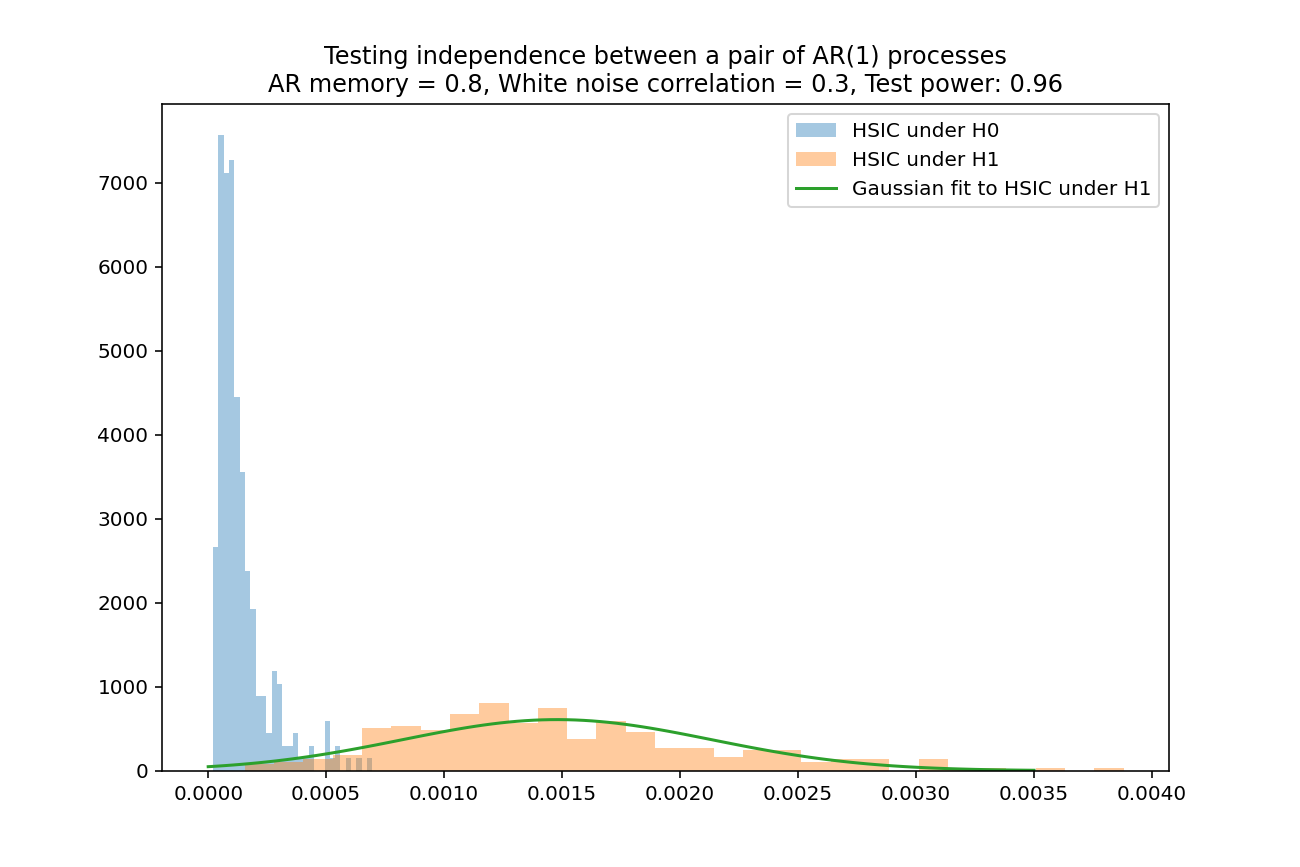

In [154]:
#plt.hist(long_scores, bins = 10, alpha = 0.4, density = True, label = 'long scores')
plt.figure(figsize = (9, 6))
plt.hist(short_scores, bins = 30, alpha = 0.4, density = True, label = 'HSIC under H0')
plt.hist(prev_data[-1]['SHORT_SCORES'], bins = 30, alpha = 0.4, density = True, label = 'HSIC under H1')

params = stats.norm.fit(prev_data[-1]['SHORT_SCORES'])
x = np.linspace(0, 0.0035, 100)
plt.title("Testing independence between a pair of AR(1) processes\nAR memory = 0.8, White noise correlation = 0.3, Test power: 0.96")
plt.plot(x, stats.norm(*params).pdf(x), label = 'Gaussian fit to HSIC under H1')
#plt.hist(BIG_RESULT_MEMORY_PLACE[0]['LONG_SCORES'], bins = 10, alpha = 0.4, density = True, label = 'long scores old')
#plt.hist(BIG_RESULT_MEMORY_PLACE[0]['SHORT_SCORES'], bins = 10, alpha = 0.4, density = True, label = 'short scores old')
plt.legend()

In [125]:
%matplotlib notebook

In [126]:
COMMENT = 'null approx in block wise bootstrap'

In [127]:
def push_results():
    BIG_RESULT_MEMORY_PLACE.append({
        'N_TIMESTEPS' : 15,
        'SIG_KERNEL_SAMPLES_NO' : NO_SAMPLES_PER_RUN,
        'M_RUNS' : NO_RUNS,
        'SHORT_SCORES' : short_scores,
        'LONG_SCORES' : long_scores,
        'RBF_SIGMA' : RBF_SIGMA,
        'DIV' : DIV,
        'TS_LEN' : TS_LEN,
        'CORR' : CORR,
        'COMMENT' : COMMENT
    })
    pp.pprint(BIG_RESULT_MEMORY_PLACE[-1])

In [128]:
push_results()

{   'COMMENT': 'null approx in block wise bootstrap',
    'CORR': 0.0,
    'DIV': 8,
    'LONG_SCORES': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [129]:
import datetime

In [130]:
import pickle
with open('./ar_hypothesis_BIG_RESULTS_{}.pickle'.format(datetime.datetime.today()).replace(' ', '_').replace(':', '.'), 'wb') as f:
    pickle.dump(BIG_RESULT_MEMORY_PLACE, f)

In [133]:
import pickle
with open('./ar_hypothesis_BIG_RESULTS_2022-02-17_18.02.49.974811.pickle', 'rb') as f:
    prev_data = pickle.load(f)